### Resumo deste Notebook:

Foi utilizado principalmente o Pandas para tratamento de dados e Tensorflow/Keras para criação do modelo de ML a ser treinado.


O modelo utilizado para treinamento foi LSTM (Long Short-Term Memory), própria para valores de séries temporais. Já que o valor atual de uma bolsa de valores segue a tendência dos valores passados, é perfeito para a aplicação de LSTM.


Foram testados modelos de 3 moedas: Bitcoin, Ethereum e Dogecoin.


### O que pode ser expandido em futuras análises:
- Mais moedas? (O limite de uso da API limitou mais moedas.)
- Mais dados históricos? (A API limita a 365 dias para o uso gratuito.)
- O dia da semana influência no valor? (Dias de segundas normalmente seguem a tendência da Sexta-Feira anterior. "Monday Effect".)
- O mês influência no valor? (O mercado é mais pessimista em Setembro. "September Effect".)

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
import requests
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import HTML


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [16]:
URL_LISTA_MOEDAS_GECKO = 'https://api.coingecko.com/api/v3/coins/markets'
URL_DADOS_HISTORICOS_GECKO = ' https://api.coingecko.com/api/v3/coins/{id}/market_chart'

In [17]:
'''Esta funcão lida com o download de dados da bolsa de valores. Utiliza da API da CoinGecko.'''
def baixar_valores():
    retorno = requests.get(
        URL_LISTA_MOEDAS_GECKO,
        params = {
            'vs_currency': 'usd', # Retornar em doláres americanos
            'order': 'market_cap_desc', # Retornar em ordem decrescente por Capitalização do Mercados
            'page': 1, # Retornar a primeira página
            'per_page': 100, # As 100 primeiras moedas
            'precision': 2, # Utilizar 2 casas decimais de precisão
        }
    )

    # Retornar como json
    return retorno.json()

In [18]:
'''Função que efetua a preparação dos dados para demonstração de valores.'''
def tratar_dados(dados):
      dataframe = pd.json_normalize(dados)

      # Remover registros que o valor atual seja nulo (i.e. moedas sem valor)
      dataframe = dataframe[dataframe[['current_price']].notnull().any(axis=1)]

      # Truncar valores
      dataframe[['current_price']] = np.trunc(100 * dataframe[['current_price']]) / 100

      # Determinar tipo de valor a partir do preço atual da moeda
      def classificar(linha):
          if linha['current_price'] > 1000:
              return 'High'
          elif linha['current_price'] >= 10:
              return 'Medium'
          else:
              return 'Low'
      dataframe['price_category'] = dataframe.apply(classificar, axis=1)

      # Retornar dataframe
      return dataframe

In [19]:
# Essa função busca o histórico de uma moeda em específico para usar em treinamento
def baixar_historico_moeda(moeda):
    url = URL_DADOS_HISTORICOS_GECKO.format(id=moeda)
    retorno = requests.get(
        url,
        params = {
            'vs_currency': 'usd', # Retornar em dólares americanos
            'days': 361, # Retornar os últimos 360 dias + o dia de hoje
            'interval': 'daily', # Retornar a primeira página
            'precision': 2, # Utilizar 2 casas decimais de precisão
        }
    )

    return retorno.json()

In [20]:
valores = baixar_valores()
dataframe = tratar_dados(valores)

# Exibir uma tabela formatada com valores mais importantes
HTML(dataframe[['name', 'symbol', 'current_price', 'price_category']].to_html(classes='table table-stripped'))

,name,symbol,current_price,price_category
0,Bitcoin,btc,63168.46,High
1,Ethereum,eth,2437.54,High
2,Tether,usdt,1.00,Low
3,BNB,bnb,564.96,Medium
4,Solana,sol,142.69,Medium
5,USDC,usdc,1.00,Low
6,XRP,xrp,0.59,Low
7,Lido Staked Ether,steth,2437.76,High
8,Dogecoin,doge,0.10,Low
9,Toncoin,ton,5.75,Low


In [21]:
'''Tratar valores recebidos pelo histórico'''
def tratar_valores_historico(dados):
    array = np.array(dados['prices'])
    dataframe = pd.DataFrame(
        {
            'timestamp': array[:-1, 0], # Excluindo o último valor (hoje)
            'valor_em_dolares': array[:-1, 1] # Excluindo o último valor (hoje)
        }
    )

    # Remover timestamp
    dataframe = dataframe.drop('timestamp', axis=1)

    return dataframe

In [22]:
TAMANHO_STEP = 90 # Usar TAMANHO_STEP dias como a janela de previsão do LSTM
SCALER = MinMaxScaler(feature_range=(0, 1))

'''Criar modelo para serem usados no LSTM'''
def criar_modelo(valores):
    X = []
    y = []
    for i in range(TAMANHO_STEP, len(valores)):
        X.append(valores[i-TAMANHO_STEP:i, :])
        y.append(valores[i, 0])


    X, y = np.array(X), np.array(y)
    return X, y

'''Essa função treina um modelo LSTM a partir de dados historicos já baixados.'''
def treinar_modelo_lstm(dados_historico, titulo):
    dataframe = tratar_valores_historico(dados_historico)

    # Reescalar para entre 0 e 1
    dataframe[['valor_escalado']] = SCALER.fit_transform(dataframe[['valor_em_dolares']])
    precos_escalados = np.asarray(dataframe.loc[:, dataframe.columns != 'valor_em_dolares'].to_numpy())

    # Separar valores para treinamento e teste
    tamanho_treino = int(len(precos_escalados) * 0.8)
    treinamento, teste = precos_escalados[:tamanho_treino], precos_escalados[tamanho_treino - TAMANHO_STEP:]

    # Gerar modelos para teste e treinamento
    X, y = criar_modelo(treinamento)
    X_teste, y_teste = criar_modelo(teste)

    # Criar modelo
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(TAMANHO_STEP, 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compilar o modelo
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Treinar o modelo
    model.fit(X, y, batch_size=1, epochs=2)
    treinamento_loss = model.evaluate(X, y, verbose=0)
    print(f'Treinamento: {treinamento_loss:.6f}')

    teste_loss = model.evaluate(X_teste, y_teste, verbose=0)
    print(f'Teste: {teste_loss:.6f}')

    # Gerar predição para análise visual
    predicao = model.predict(X_teste)
    predicao = SCALER.inverse_transform(predicao)

    df_treinamento = dataframe[:tamanho_treino]
    df_valido = dataframe[tamanho_treino:]
    df_valido['predicoes'] = predicao

    # Visualizar as informações
    plt.figure(figsize=(16,6))
    plt.title(titulo)
    plt.xlabel('Tempo', fontsize=18)
    plt.ylabel('Preço em Dólares (USD)', fontsize=18)
    plt.plot(df_treinamento['valor_em_dolares'])
    plt.plot(df_valido[['valor_em_dolares', 'predicoes']])
    plt.legend(['Treinamento', 'Valores', 'Predição'], loc='lower right')
    plt.show()

Epoch 1/2
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0254
Epoch 2/2
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0085
Treinamento: 0.004163
Teste: 0.006319
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


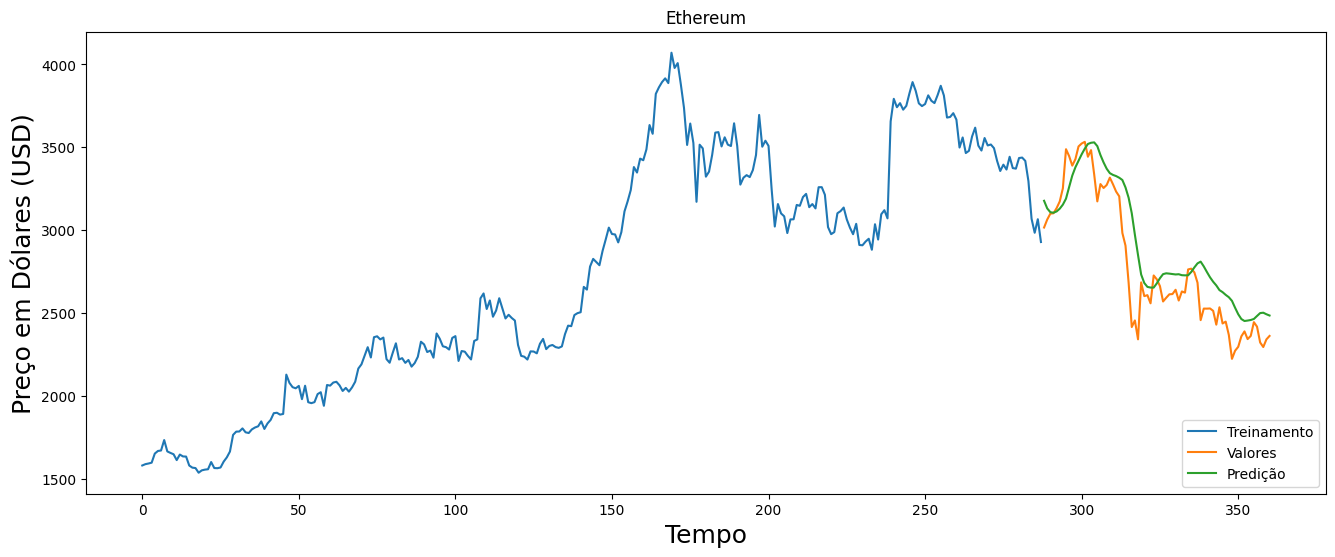

In [23]:
dados_historico = baixar_historico_moeda('ethereum')
treinar_modelo_lstm(dados_historico, 'Ethereum')

Epoch 1/2
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0766
Epoch 2/2
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0082
Treinamento: 0.003771
Teste: 0.004927
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


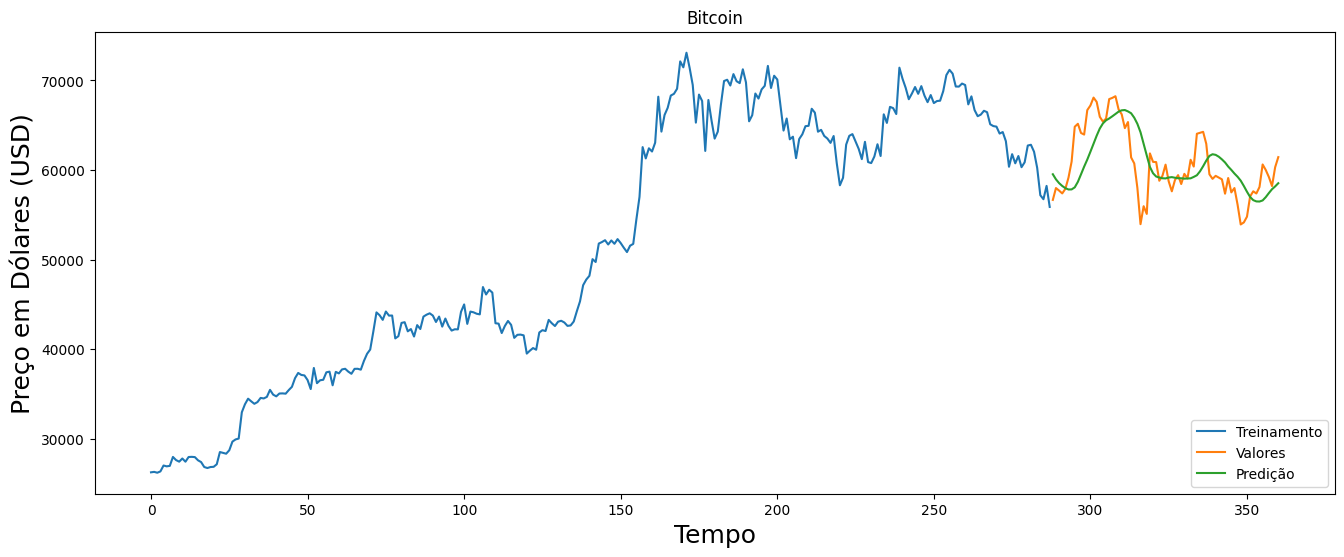

In [24]:
dados_historico = baixar_historico_moeda('bitcoin')
treinar_modelo_lstm(dados_historico, 'Bitcoin')

Epoch 1/2
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0322
Epoch 2/2
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0119
Treinamento: 0.006660
Teste: 0.003354
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


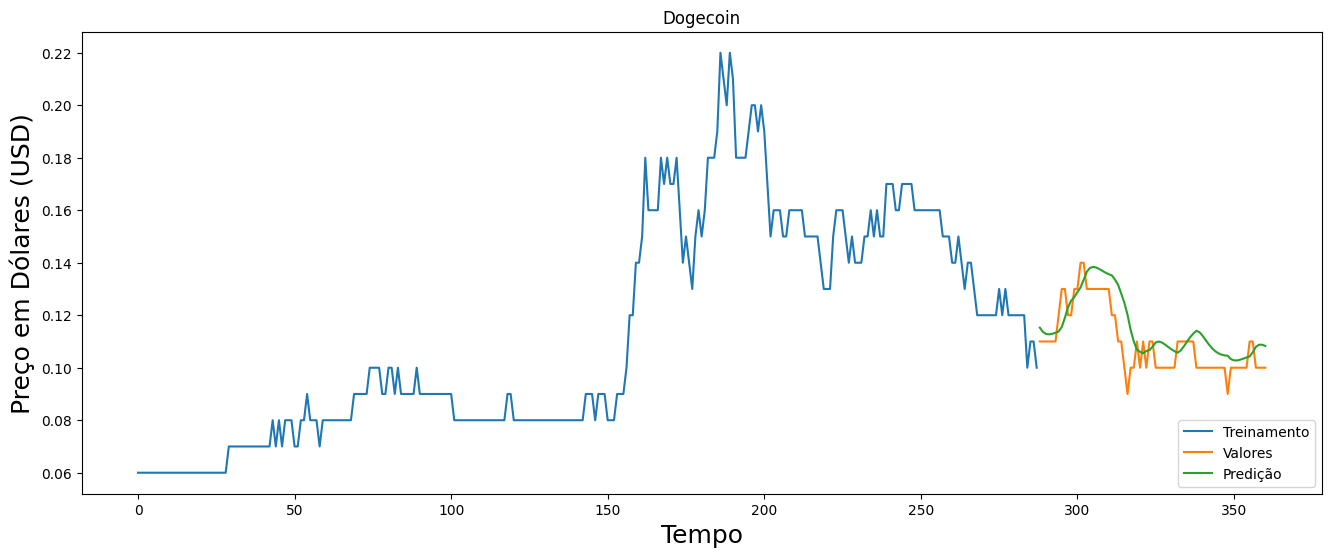

In [25]:
dados_historico = baixar_historico_moeda('dogecoin')
treinar_modelo_lstm(dados_historico, 'Dogecoin')